<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Final-Feature-Engineering" data-toc-modified-id="1.-Final-Feature-Engineering-1">1. Final Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Feature-Scaling" data-toc-modified-id="Feature-Scaling-1.1">Feature Scaling</a></span></li></ul></li><li><span><a href="#2.-Model-With-Outliers" data-toc-modified-id="2.-Model-With-Outliers-2">2. Model With Outliers</a></span><ul class="toc-item"><li><span><a href="#2.1-Logistic-Model(Without-SMOTE)" data-toc-modified-id="2.1-Logistic-Model(Without-SMOTE)-2.1">2.1 Logistic Model(Without SMOTE)</a></span></li><li><span><a href="#2.2-Logistic-Model(With-SMOTE)" data-toc-modified-id="2.2-Logistic-Model(With-SMOTE)-2.2">2.2 Logistic Model(With SMOTE)</a></span></li></ul></li><li><span><a href="#3.-Model-Without-Outliers" data-toc-modified-id="3.-Model-Without-Outliers-3">3. Model Without Outliers</a></span><ul class="toc-item"><li><span><a href="#3.1-Logistic-Model-(With-SMOTE)" data-toc-modified-id="3.1-Logistic-Model-(With-SMOTE)-3.1">3.1 Logistic Model (With SMOTE)</a></span></li><li><span><a href="#3.2-Logistic-Model(Without-SMOTE)" data-toc-modified-id="3.2-Logistic-Model(Without-SMOTE)-3.2">3.2 Logistic Model(Without SMOTE)</a></span></li></ul></li></ul></div>

In [ ]:
import pandas as pd 
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import shap

In [ ]:
df_train = pd.read_pickle('../Data/df_train_with_outliers.pkl')
df_test = pd.read_pickle('../Data/df_test_with_outliers.pkl')

# df_train = pd.read_pickle('../Data/part2_df_train_NO_outliers.pkl')
# df_test = pd.read_pickle('../Data/part2_df_test_NO_outliers.pkl')

## 1. Final Feature Engineering

In [ ]:
X_train = df_train.drop(['loan_status'], axis=1)
y_train = df_train.loc[:, 'loan_status']

X_test = df_test.drop(['loan_status'], axis=1)
y_test = df_test['loan_status']

### Feature Scaling

As features are measured in different units, they cover different ranges. Some ML models, such as SVM, KNN that take into account distance measures between observations are therefore significantly affected by the range of the features and scaling allows them to learn. While some methods, such as Linear Regression and Ransom Forest do not actually require feature scaling, it's still best practice to take this step when we are comparing multiple algorithms.

Removing mean and dividing the standard deviation of features respectively.

In [ ]:
# Create an imputer object with a median filling strategy
scaler = StandardScaler()

# Train on the training features
scaler.fit(X_train)

# Transform both training and testing data
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## 2. Model With Outliers

### 2.1 Logistic Model(Without SMOTE)

In [ ]:
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

In [ ]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

In [ ]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
plt.savefig('../Figures/log_roc_outliers_no_smote')
plt.show()

In [ ]:
lr_probs = logreg.predict_proba(X_test)
lr_probs = lr_probs[:, 0]
# predict class values
yhat = logreg.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.2f auc=%.2f' % (lr_f1, lr_auc))



plt.figure(figsize=(10, 10))
plt.plot(lr_recall, lr_precision, label='Logistic Regression (area = %0.2f)' % lr_auc)
#plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
# plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
plt.savefig('../Figures/log_prauc_outliers_no_smote')
plt.show()

### 2.2 Logistic Model(With SMOTE)

In [ ]:
sm = SMOTE(random_state=12, n_jobs = -1, k_neighbors=5, sampling_strategy='auto')
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
logreg_smote = LogisticRegression()
logreg_smote.fit(X_train, y_train)

In [ ]:
y_pred = logreg_smote.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_smote.score(X_test, y_test)))

In [ ]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg_smote.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg_smote.predict_proba(X_test)[:,1])
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
plt.savefig('../Figures/log_roc_outliers_smote')
plt.show()

In [ ]:
lr_probs = logreg_smote.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
# predict class values
yhat = logreg_smote.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.2f auc=%.2f' % (lr_f1, lr_auc))



plt.figure(figsize=(10, 10))
plt.plot(lr_recall, lr_precision, label='Logistic Regression (area = %0.2f)' % lr_auc)
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
# plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
plt.savefig('../Figures/log_prauc_outliers_no_smote')
plt.show()

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg_smote.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg_smote.predict_proba(X_test)[:,1])
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
plt.savefig('../Figures/log_roc_outliers_smote')
plt.show()

Logistic: f1=0.76 auc=0.92


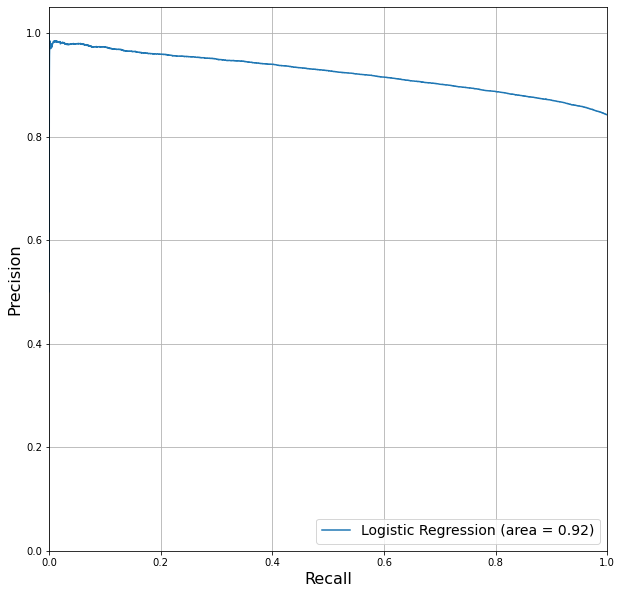

In [11]:
lr_probs = logreg_smote.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
# predict class values
yhat = logreg_smote.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.2f auc=%.2f' % (lr_f1, lr_auc))



plt.figure(figsize=(10, 10))
plt.plot(lr_recall, lr_precision, label='Logistic Regression (area = %0.2f)' % lr_auc)
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
# plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
plt.savefig('../Figures/log_prauc_outliers_no_smote')
plt.show()

## 3. Model Without Outliers

### 3.1 Logistic Model (With SMOTE)

In [ ]:
sm = SMOTE(random_state=12, n_jobs = -1, k_neighbors=5, sampling_strategy='auto')
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

In [ ]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

In [ ]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
plt.savefig('../Figures/log_roc_no_outliers_smote')
plt.show()

### 3.2 Logistic Model(Without SMOTE)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

In [ ]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

In [ ]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
plt.savefig('../Figures/log_roc_no_outliers_no_smote')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
plt.savefig('../Figures/log_roc_no_outliers_no_smote')
plt.show()